In [5]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk

DF = pd.read_csv('/content/Autor_detection.csv')
DF.head()

#stopworldslerin analizi yanlış yönlendirmesini engellemek için
nltk.download('stopwords')

counts = DF['Writter name'].value_counts()
print("max: ", counts.max(),"- min: ", counts.min(),"- mean: ", counts.mean() , "std: ", counts.std())

counts_greater_100 = counts[counts > 100]
print("Number of authors with more than 100 samples: ", counts_greater_100)

# counts_greater_120 = counts[counts > 120]
# print("Number of authors with more than 120 samples: ", counts_greater_120)


max:  191 - min:  1 - mean:  19.012048192771083 std:  41.312460169614006
Number of authors with more than 100 samples:  Writter name
Jane Austen            191
J.R.R. Tolkien         158
John Steinbeck         147
Charles Dickens        147
William Shakespeare    139
Ernest Hemingway       114
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#-------------ALL FUNCTİONS--------------
def clean_and_std_data(df):

    df = df.dropna(subset=['Quotes'])

    def is_english(text):
        try:
            text.encode("ascii")
            return True
        except UnicodeEncodeError:
            return False

    english_quotes = df[df['Quotes'].apply(lambda x: is_english(str(x)))]
    english_quotes['Quotes'] = english_quotes['Quotes'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True).str.strip()

    print(f"Orijinal veri seti büyüklüğü: {len(df)}")
    print(f"İngilizce quotes sayısı: {len(english_quotes)}")
    print(f"Elenen quote sayısı: {len(df) - len(english_quotes)}")
    return english_quotes

def get_word_freqs(df,top = 20):
    STOP_WORDS = set(stopwords.words('english'))
    author_word_freqs = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        all_words = ' '.join(author_quotes).split()
        # Stop words'leri filtrele
        all_words = [word for word in all_words if word not in STOP_WORDS and len(word) > 1]
        word_freq = pd.Series(all_words).value_counts().head(top)
        author_word_freqs[author] = word_freq
    return author_word_freqs


def get_avg_quote_length_for_author(df):
    author_avg_word_length = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        avg_length = author_quotes.apply(lambda x: len(x.split())).mean()
        author_avg_word_length[author] = avg_length
    return author_avg_word_length

def get_frequent_ngrams(df,n=2, top=20):
    STOP_WORDS = set(stopwords.words('english'))
    author_ngram_freqs = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        all_ngrams = []
        for quote in author_quotes:
            # Kelimeleri böl ve stop words'leri filtrele
            words = [word for word in quote.split()
                    if word not in STOP_WORDS and len(word) > 1]

            if len(words) >= n:  # n-gram oluşturmak için yeterli kelime var mı
                ngram_list = list(nltk.ngrams(words, n))
                all_ngrams.extend(ngram_list)

        if all_ngrams:
            ngram_freq = pd.Series(all_ngrams).value_counts().head(top)
            author_ngram_freqs[author] = ngram_freq
        else:
            author_ngram_freqs[author] = pd.Series()

    return author_ngram_freqs

def get_word_diversity_for_author(df):
    author_word_diversity = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        all_words = ' '.join(author_quotes).split()
        unique_words = set(all_words)
        diversity = len(unique_words) / len(all_words) if len(all_words) > 0 else 0
        author_word_diversity[author] = diversity
    return author_word_diversity

def get_author_uniqueness_score(df):
    """
    Her yazarın diğer yazarlara göre ne kadar benzersiz kelime kullandığını hesaplar
    """
    STOP_WORDS = set(stopwords.words('english'))

    all_authors_words = set()
    author_word_sets = {}

    # Her yazarın kelime setini oluştur
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        words = set(' '.join(author_quotes).split())
        # Stop words'leri çıkar
        words = {word for word in words if word not in STOP_WORDS and len(word) > 1}
        author_word_sets[author] = words
        all_authors_words.update(words)

    # Her yazar için benzersizlik skoru hesapla
    author_uniqueness = {}
    for author, words in author_word_sets.items():
        # Diğer yazarların kelimelerini topla
        other_authors_words = set()
        for other_author, other_words in author_word_sets.items():
            if other_author != author:
                other_authors_words.update(other_words)

        # Benzersiz kelimeler: Sadece bu yazarın kullandığı kelimeler
        unique_words = words - other_authors_words

        # Benzersizlik skoru: Yazarın benzersiz kelimelerinin toplam kelimelerine oranı
        uniqueness_score = len(unique_words) / len(words) if len(words) > 0 else 0
        author_uniqueness[author] = uniqueness_score

    return author_uniqueness

def get_lwr_and_avg_world_len(df):
    #lwr = long word ratio

    STOP_WORDS = set(stopwords.words('english'))

    author_complexity = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']

        # Ortalama kelime uzunluğu
        all_words = ' '.join(author_quotes).split()
        all_words = [word for word in all_words if word not in STOP_WORDS and len(word) > 1]
        avg_word_length = sum(len(word) for word in all_words) / len(all_words) if all_words else 0

        # Uzun kelime oranı (6+ karakter)
        long_words = [word for word in all_words if len(word) > 6]
        long_word_ratio = len(long_words) / len(all_words) if all_words else 0

        author_complexity[author] = {
            'avg_word_length': avg_word_length,
            'long_word_ratio': long_word_ratio
        }

    return pd.DataFrame.from_dict(author_complexity, orient='index')

def pick_writers(df,limit=120):
    counts = df['Writter name'].value_counts()
    selected_authors = counts[counts > limit].index
    filtered_df = df[df['Writter name'].isin(selected_authors)]
    print(f"Seçilen yazar sayısı: {len(selected_authors)}")
    print(f"Filtrelenmiş veri seti büyüklüğü: {len(filtered_df)}")
    return filtered_df

In [8]:
cleaned_DF = clean_and_std_data(DF)
print(cleaned_DF.head())
print("\n")

counts = cleaned_DF['Writter name'].value_counts()
print("max: ", counts.max(),"- min: ", counts.min(),"- mean: ", counts.mean() , "std: ", counts.std())
print("\n")

counts_greater_100 = counts[counts > 100]
print("Number of authors with more than 100 samples: ", counts_greater_100)
print("\n")

counts_greater_120 = counts[counts > 120]
print("Number of authors with more than 120 samples: ", counts_greater_120)


Orijinal veri seti büyüklüğü: 1571
İngilizce quotes sayısı: 1566
Elenen quote sayısı: 5
                                              Quotes      Writter name
0  reading kafka i sense that the elicited questi...  Alberto Manguel,
1  all animals are equal but some animals are mor...     George Orwell
2  i am old gandalf i dont look it but i am begin...    J.R.R. Tolkien
3  how can we live without our lives how will we ...    John Steinbeck
4  i was only foolin george i dont want no ketchu...    John Steinbeck


max:  191 - min:  1 - mean:  19.575 std:  41.69199145997631


Number of authors with more than 100 samples:  Writter name
Jane Austen            191
J.R.R. Tolkien         158
John Steinbeck         147
Charles Dickens        147
William Shakespeare    132
Ernest Hemingway       114
Name: count, dtype: int64


Number of authors with more than 120 samples:  Writter name
Jane Austen            191
J.R.R. Tolkien         158
John Steinbeck         147
Charles Dickens        147
Will

/tmp/ipython-input-12327140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_quotes['Quotes'] = english_quotes['Quotes'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True).str.strip()


In [ ]:
# NaN double checkpoint
print("\nBoş string kontrolü:", cleaned_DF[cleaned_DF['Quotes'] == ''].shape[0])
print("pd.NA kontrolü:", cleaned_DF[cleaned_DF['Quotes'].isna()].shape[0])
print("np.nan kontrolü:", cleaned_DF[cleaned_DF['Quotes'].isnull()].shape[0])

#word_freq feature ekleme
word_freqs = get_word_freqs(cleaned_DF, top=20)
cleaned_DF["word_freqs"] = cleaned_DF['Writter name'].map(word_freqs)

#n=2 ve n=3 için ngram feature ekleme
bigrams = get_frequent_ngrams(cleaned_DF, n=2, top=20)
cleaned_DF["bigram_freqs"] = cleaned_DF['Writter name'].map(bigrams)
trigrams = get_frequent_ngrams(cleaned_DF, n=3, top=20)
cleaned_DF["trigram_freqs"] = cleaned_DF['Writter name'].map(trigrams)

#yazarın quotelarında kullandığı kelime çeşitliliğini represent eden feature ekleme
word_diversities = get_word_diversity_for_author(cleaned_DF)
cleaned_DF["word_diversity_"] = cleaned_DF['Writter name'].map(word_diversities)

#author uniquness score ekleme : get_author_uniqueness_score func altında feature tanımı bulunmakta
uniqueness_scores = get_author_uniqueness_score(cleaned_DF)
cleaned_DF["author_uniqueness_score"] = cleaned_DF['Writter name'].map(uniqueness_scores)

#lwr ve avg word length ekleme, lwr: long word ratio
complexity_df = get_lwr_and_avg_world_len(cleaned_DF)
cleaned_DF = cleaned_DF.merge(complexity_df, left_on='Writter name', right_index=True, how='left')


#avg quote length ekleme
avg_lengths = get_avg_quote_length_for_author(cleaned_DF)
cleaned_DF["avg_quote_length(by words)"] = cleaned_DF['Writter name'].map(avg_lengths)
cleaned_DF.head()





Boş string kontrolü: 0
pd.NA kontrolü: 0
np.nan kontrolü: 0


,Quotes,Writter name,word_freqs,bigram_freqs,trigram_freqs,word_diversity_,author_uniqueness_score,avg_word_length,long_word_ratio,avg_quote_length(by words)
0,reading kafka i sense that the elicited questi...,"Alberto Manguel,",next 2 kafka 2 readin...,"(reading, kafka) 1 (something, ...","(reading, kafka, sense) 1 ...",0.901961,0.357143,7.100000,0.466667,51.000000
1,all animals are equal but some animals are mor...,George Orwell,one 11 man 10 would 8 l...,"(animals, equal) 4 (animal, shall)...","(whatever, goes, upon) 2 (great...",0.365700,0.280412,5.977364,0.356858,22.985507
2,i am old gandalf i dont look it but i am begin...,J.R.R. Tolkien,one 20 like 19 ring 19 s...,"(one, ring) 8 (said, bilbo) ...","(one, ring, rule) 3 (ring, rule, on...",0.256083,0.349872,5.287073,0.218764,31.734177
3,how can we live without our lives how will we ...,John Steinbeck,people 20 like 18 get 17 know ...,"(seemed, know) 4 (george, said) 3 ...","(make, feel, rich) 3 (along, work...",0.289151,0.328846,5.384538,0.235978,27.149660
4,i was only foolin george i dont want no ketchu...,John Steinbeck,people 20 like 18 get 17 know ...,"(seemed, know) 4 (george, said) 3 ...","(make, feel, rich) 3 (along, work...",0.289151,0.328846,5.384538,0.235978,27.149660


In [9]:
cleaned_DF = pick_writers(cleaned_DF,120)
cleaned_DF.head()

Seçilen yazar sayısı: 5
Filtrelenmiş veri seti büyüklüğü: 775


,Quotes,Writter name
2,i am old gandalf i dont look it but i am begin...,J.R.R. Tolkien
3,how can we live without our lives how will we ...,John Steinbeck
4,i was only foolin george i dont want no ketchu...,John Steinbeck
6,there is nothing i would not do for those who ...,Jane Austen
8,short cuts make long delays,J.R.R. Tolkien


In [11]:
# test yapılırken kullanabilecek bir hal

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Türkçe karakterleri düzgün gösterme
pd.set_option('display.max_colwidth', None)

# İngilizce stop words'leri indirme
nltk.download('stopwords')
nltk.download('punkt')

# Veri setini okuma
df = pd.read_csv('Autor_detection.csv')

# Veri temizleme fonksiyonunu güncelleme
def clean_and_std_data(df):
    # 1. Boş alıntıları kaldırma
    df = df.dropna(subset=['Quotes'])

    # 2. Metinleri string'e çevirme ve temizleme
    df['Quotes'] = df['Quotes'].astype(str)

    # 3. Türkçe karakter kontrolü - İngilizce olmayanları filtreleme
    def is_english(text):
        try:
            text.encode('ascii')
            return True
        except UnicodeEncodeError:
            return False

    # İngilizce alıntıları seçme
    english_quotes = df[df['Quotes'].apply(lambda x: is_english(x))]
    print(f"Orijinal veri seti büyüklüğü: {len(df)}")
    print(f"İngilizce quotes sayısı: {len(english_quotes)}")
    print(f"Elenen quote sayısı: {len(df) - len(english_quotes)}")

    # 4. Metinleri küçük harfe çevirme ve özel karakterleri temizleme
    english_quotes['clean_quotes'] = english_quotes['Quotes'].str.lower()
    english_quotes['clean_quotes'] = english_quotes['clean_quotes'].apply(
        lambda x: re.sub(r'[^a-z\s]', '', x)
    )
    english_quotes['clean_quotes'] = english_quotes['clean_quotes'].str.strip()
    english_quotes['clean_quotes'] = english_quotes['clean_quotes'].apply(
        lambda x: re.sub(r'\s+', ' ', x)
    )

    # 5. Çok kısa alıntıları filtreleme (en az 5 kelime)
    english_quotes['word_count'] = english_quotes['clean_quotes'].apply(
        lambda x: len(x.split())
    )
    english_quotes = english_quotes[english_quotes['word_count'] >= 5]

    # 6. Yazar adlarındaki gereksiz boşlukları ve noktalama işaretlerini temizleme
    english_quotes['Writter name'] = english_quotes['Writter name'].str.strip()
    english_quotes['Writter name'] = english_quotes['Writter name'].str.replace(',', '')
    english_quotes['Writter name'] = english_quotes['Writter name'].str.title()

    return english_quotes

# Veri temizleme işlemini gerçekleştirme
cleaned_df = clean_and_std_data(df)

Orijinal veri seti büyüklüğü: 1571
İngilizce quotes sayısı: 1566
Elenen quote sayısı: 5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Yazarların frekans dağılımı
author_counts = cleaned_df['Writter name'].value_counts()

# En az 120 örneği olan yazarları seçme - dengeli bir veri seti için
min_samples = 120
selected_authors = author_counts[author_counts >= min_samples].index
filtered_df = cleaned_df[cleaned_df['Writter name'].isin(selected_authors)]

print(f"Seçilen {len(selected_authors)} yazar: {list(selected_authors)}")
print(f"Filtrelenmiş veri seti büyüklüğü: {len(filtered_df)}")

# Dengesizlik oranı kontrolü
print("\nYazar dağılımı:")
print(filtered_df['Writter name'].value_counts())
print("\nDengesizlik oranı (en çok/en az):",
      filtered_df['Writter name'].value_counts().max() / filtered_df['Writter name'].value_counts().min())

Seçilen 5 yazar: ['Jane Austen', 'J.R.R. Tolkien', 'John Steinbeck', 'Charles Dickens', 'William Shakespeare']
Filtrelenmiş veri seti büyüklüğü: 765

Yazar dağılımı:
Writter name
Jane Austen            190
J.R.R. Tolkien         157
John Steinbeck         146
Charles Dickens        145
William Shakespeare    127
Name: count, dtype: int64

Dengesizlik oranı (en çok/en az): 1.4960629921259843


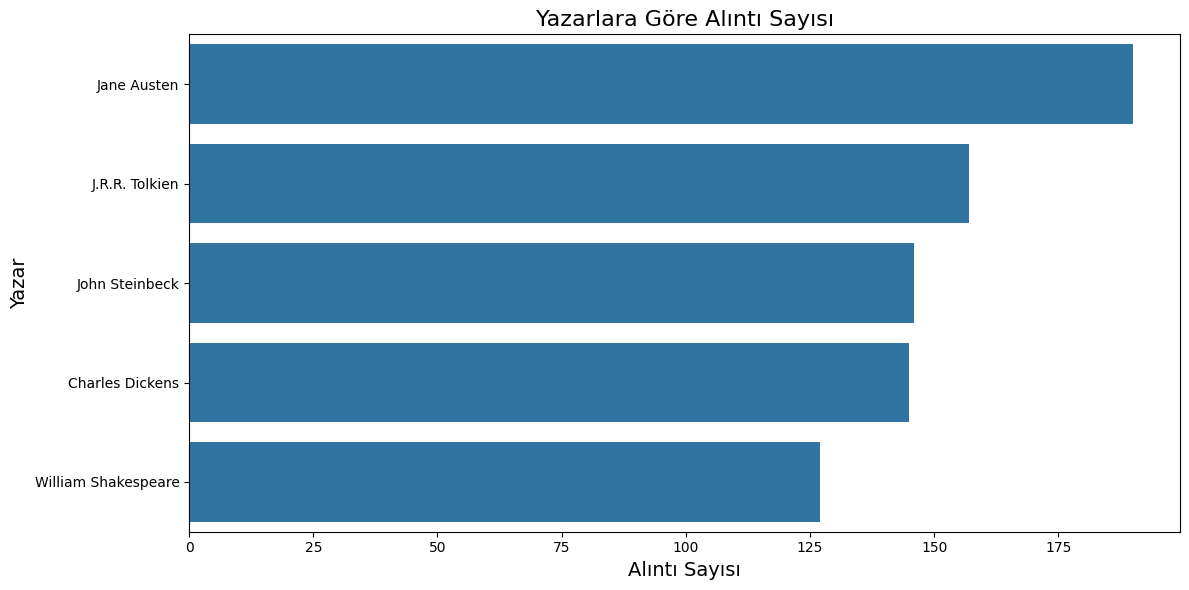

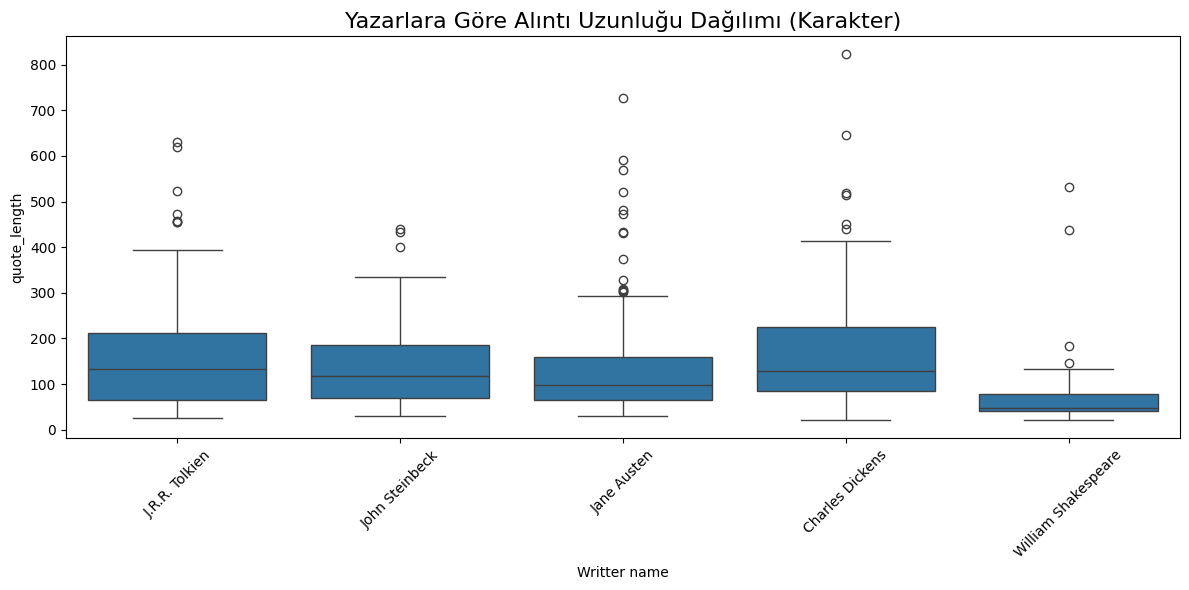

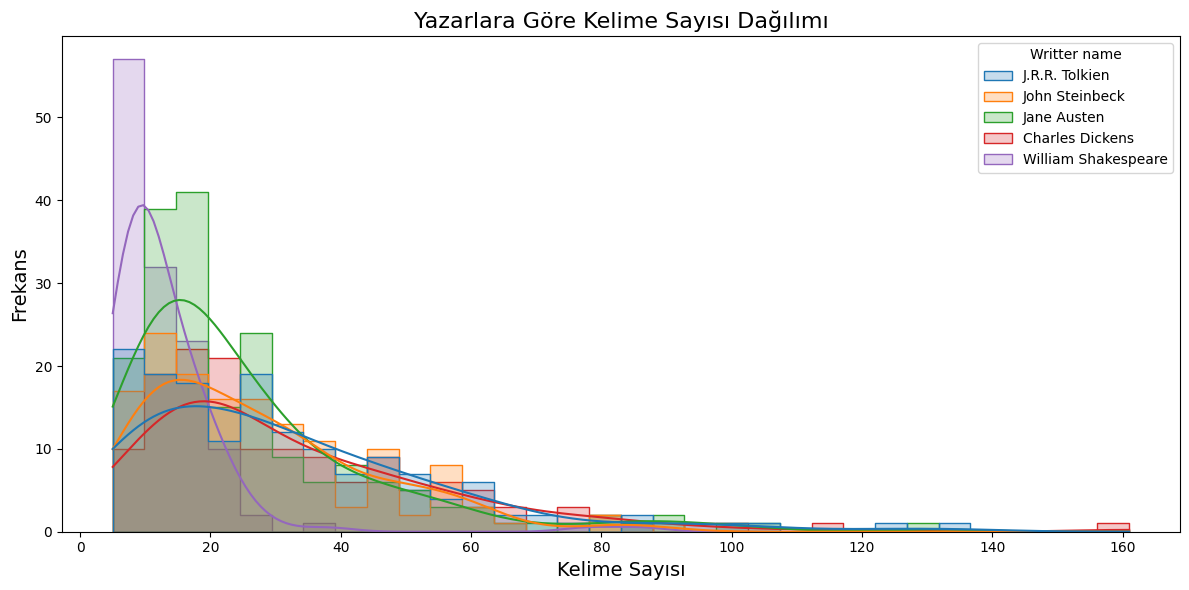

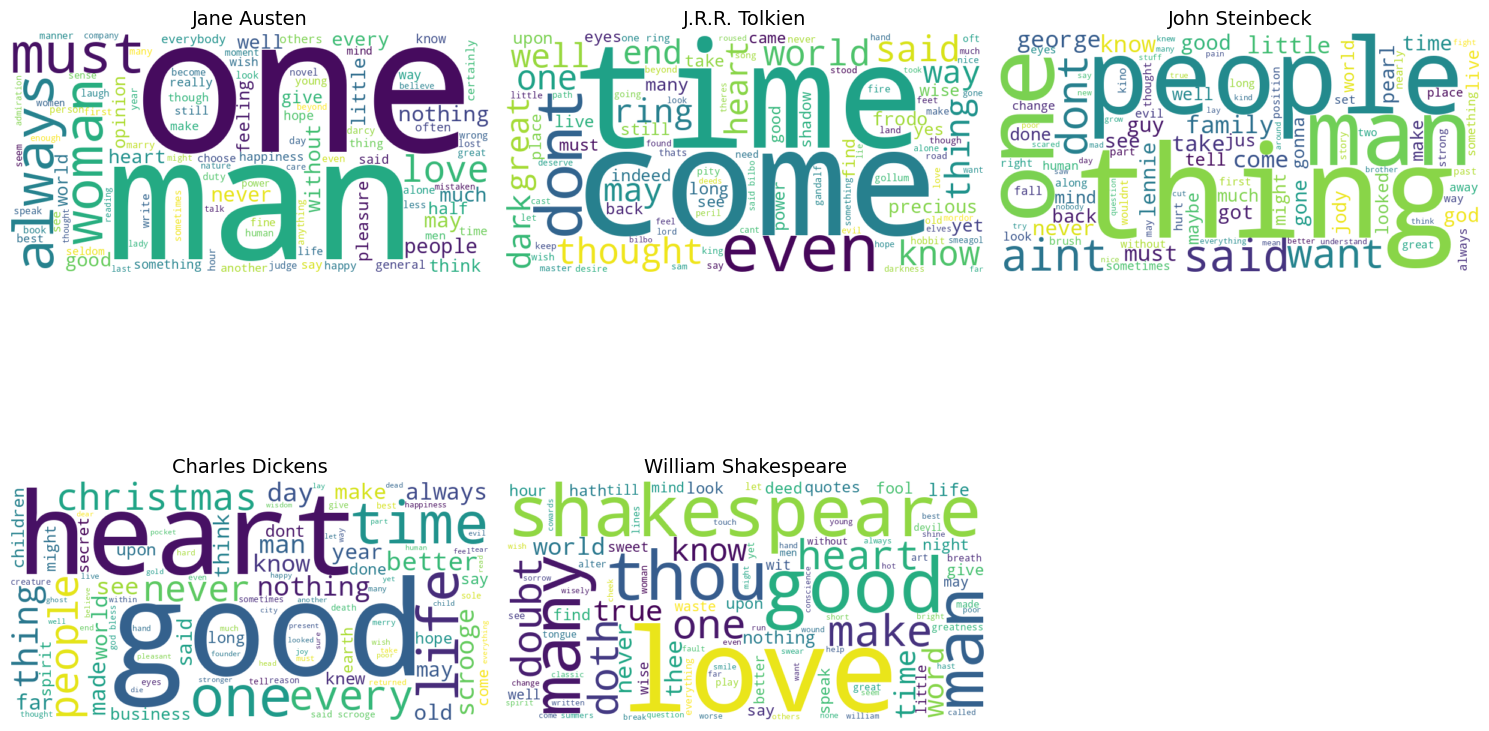

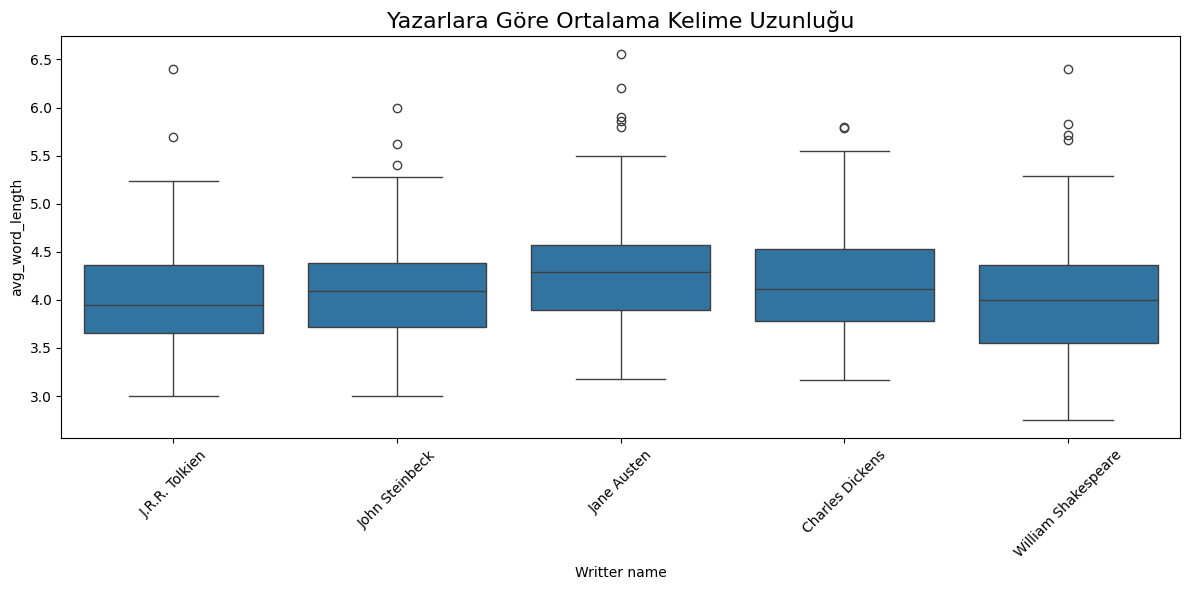

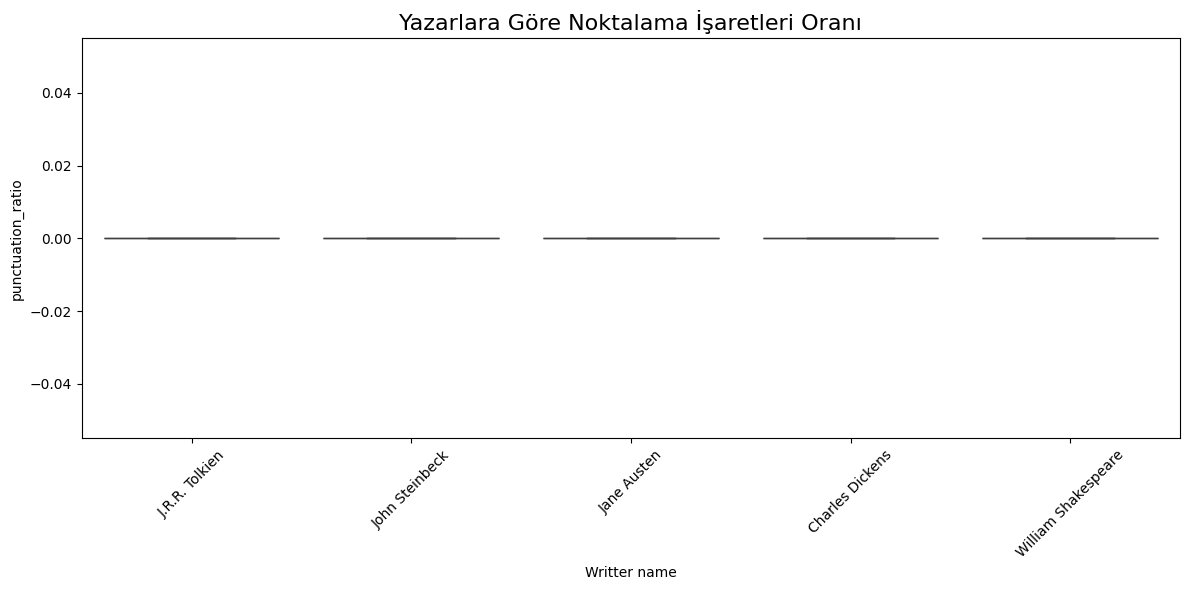

In [25]:
# EDA (Detaylı Keşifsel Veri Analizi)
# Yazar frekans grafiği
plt.figure(figsize=(12, 6))
sns.countplot(y='Writter name', data=filtered_df, order=filtered_df['Writter name'].value_counts().index)
plt.title('Yazarlara Göre Alıntı Sayısı', fontsize=16)
plt.xlabel('Alıntı Sayısı', fontsize=14)
plt.ylabel('Yazar', fontsize=14)
plt.tight_layout()
plt.savefig('author_distribution.png')
plt.show()

# Alıntı uzunluğu analizi
filtered_df['quote_length'] = filtered_df['clean_quotes'].apply(lambda x: len(x))
filtered_df['word_count'] = filtered_df['clean_quotes'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='Writter name', y='quote_length', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Yazarlara Göre Alıntı Uzunluğu Dağılımı (Karakter)', fontsize=16)
plt.tight_layout()
plt.savefig('quote_length_by_author.png')
plt.show()

# Kelime sayısı dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(data=filtered_df, x='word_count', hue='Writter name', kde=True, element='step', common_norm=False)
plt.title('Yazarlara Göre Kelime Sayısı Dağılımı', fontsize=16)
plt.xlabel('Kelime Sayısı', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.tight_layout()
plt.savefig('word_count_distribution.png')
plt.show()

# En sık kullanılan kelimeler - WordCloud ile görselleştirme
from wordcloud import WordCloud

plt.figure(figsize=(15, 10))
for i, author in enumerate(selected_authors):
    author_texts = filtered_df[filtered_df['Writter name'] == author]['clean_quotes']
    all_text = ' '.join(author_texts.tolist())

    # Stop words'leri filtreleme
    STOP_WORDS = set(stopwords.words('english'))
    words = all_text.split()
    filtered_words = [word for word in words if word not in STOP_WORDS and len(word) > 2]
    filtered_text = ' '.join(filtered_words)

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(filtered_text)

    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{author}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.savefig('wordclouds_by_author.png')
plt.show()

# Ortalama kelime uzunluğu analizi
def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

filtered_df['avg_word_length'] = filtered_df['clean_quotes'].apply(avg_word_length)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Writter name', y='avg_word_length', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Yazarlara Göre Ortalama Kelime Uzunluğu', fontsize=16)
plt.tight_layout()
plt.savefig('avg_word_length_by_author.png')
plt.show()

# Noktalama işaretleri analizi
import string

def punctuation_ratio(text):
    punct_count = sum(1 for char in text if char in string.punctuation)
    return punct_count / len(text) if len(text) > 0 else 0

filtered_df['punctuation_ratio'] = filtered_df['Quotes'].apply(punctuation_ratio)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Writter name', y='punctuation_ratio', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Yazarlara Göre Noktalama İşaretleri Oranı', fontsize=16)
plt.tight_layout()
plt.savefig('punctuation_ratio_by_author.png')
plt.show()

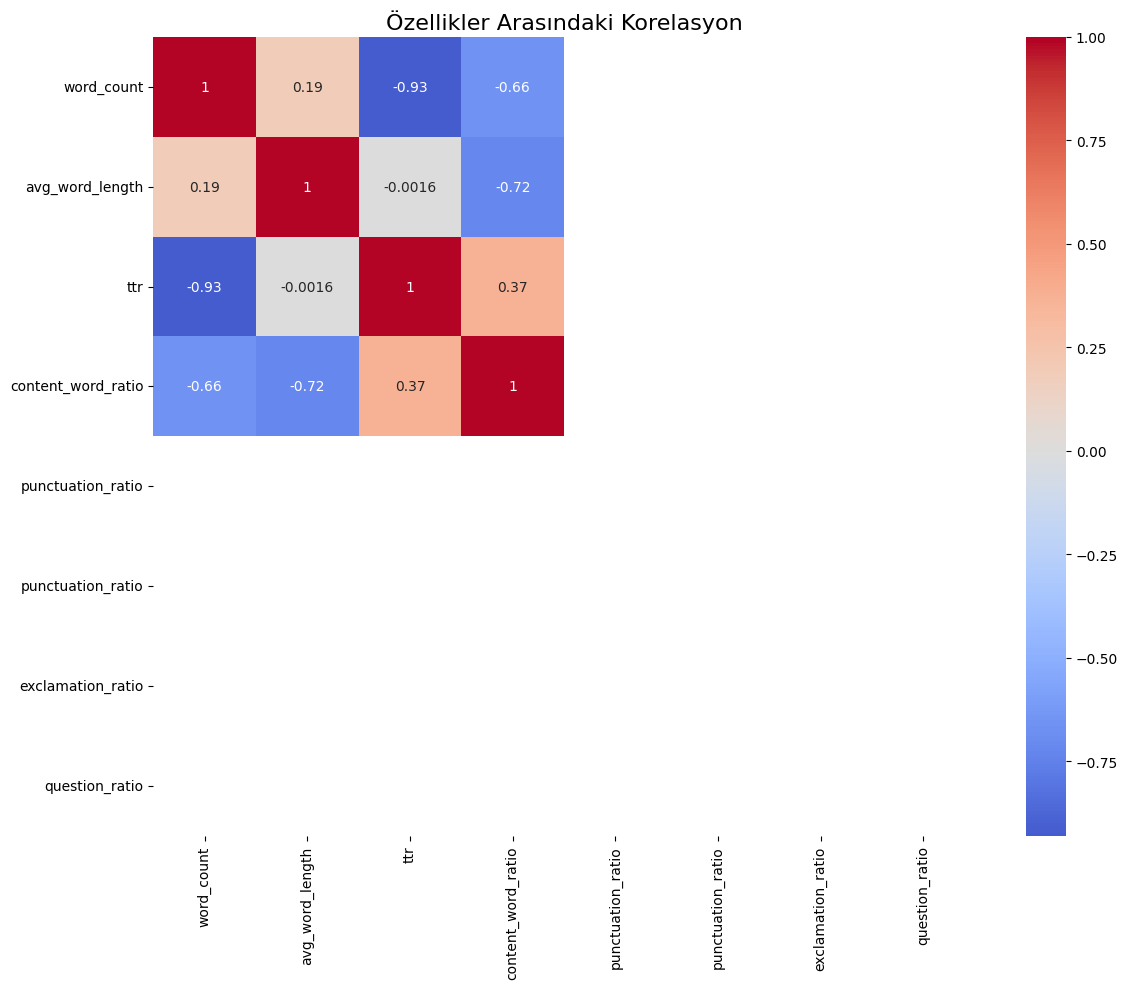

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# stopwords güvenli şekilde yükleme (nltk yoksa sklearn'e dön)
try:
    from nltk.corpus import stopwords
    STOP_WORDS = set(stopwords.words('english'))
except Exception:
    try:
        import nltk
        nltk.download('stopwords', quiet=True)
        from nltk.corpus import stopwords
        STOP_WORDS = set(stopwords.words('english'))
    except Exception:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
        STOP_WORDS = set(ENGLISH_STOP_WORDS)

# Stilometrik özellik çıkarımı için fonksiyonlar
def extract_stylometric_features(df):
    df = df.copy()

    # Ensure text columns exist and are strings (fix for float/NaN)
    if 'clean_quotes' not in df.columns:
        df['clean_quotes'] = ''
    else:
        df['clean_quotes'] = df['clean_quotes'].fillna('').astype(str)

    if 'Quotes' not in df.columns:
        df['Quotes'] = ''
    else:
        df['Quotes'] = df['Quotes'].fillna('').astype(str)

    # 1. Temel metrikler
    df['word_count'] = df['clean_quotes'].apply(lambda x: len(str(x).split()))
    df['avg_word_length'] = df['clean_quotes'].apply(
        lambda x: (sum(len(word) for word in str(x).split()) / len(str(x).split())) if len(str(x).split()) > 0 else 0
    )

    # 2. Noktalama özellikleri (okunabilir isimlerle)
    punct_map = {
        '.': 'dot', ',': 'comma', ';': 'semicolon', ':': 'colon',
        '!': 'exclamation', '?': 'question', '"': 'doublequote', "'": 'singlequote'
    }

    def count_punctuation(text):
        text = '' if pd.isna(text) else str(text)
        counts = {}
        total = 0
        for ch, name in punct_map.items():
            c = text.count(ch)
            counts[name] = c
            total += c
        # Avoid division by zero
        total_nonzero = total or 1
        ratios = {f"{name}_ratio": counts[name] / total_nonzero for name in counts}
        # ayrıca toplam noktalama oranı (noktalama işareti sayısı / karakter sayısı)
        punctuation_ratio = (sum(counts.values()) / len(text)) if len(text) > 0 else 0
        ratios['punctuation_ratio'] = punctuation_ratio
        return ratios

    punct_df = df['clean_quotes'].apply(count_punctuation).apply(pd.Series)
    df = pd.concat([df, punct_df], axis=1)

    # 3. Kelime uzunluğu dağılımı (1..10, 10+'lar 10. kategoriye konur)
    def word_length_distribution(text):
        text = '' if pd.isna(text) else str(text)
        words = [w for w in text.split() if w.isalpha()]
        lengths = [len(w) for w in words]
        if not lengths:
            return [0] * 10
        dist = [0] * 10
        for l in lengths:
            idx = l - 1 if l <= 10 else 9
            dist[idx] += 1
        total = sum(dist) or 1
        return [d / total for d in dist]

    word_len_df = pd.DataFrame(
        df['clean_quotes'].apply(word_length_distribution).tolist(),
        columns=[f'word_len_{i}' for i in range(1, 11)]
    )
    df = pd.concat([df, word_len_df], axis=1)

    # 4. Fonksiyon kelime oranları (kelime bazlı, küçük harfe çevirerek)
    function_words = [
        'the', 'and', 'to', 'of', 'a', 'in', 'that', 'it', 'is', 'i', 'you', 'he', 'she', 'we', 'they',
        'this', 'these', 'those', 'my', 'your', 'his', 'her', 'our', 'their', 'be', 'have', 'do', 'can',
        'will', 'would', 'should', 'could', 'may', 'might', 'must'
    ]
    # Daha sağlam hesaplama: önce token'ları oluştur, sonra oranı hesapla
    def func_word_ratio_factory(target_word):
        def ratio(text):
            text = '' if pd.isna(text) else str(text)
            tokens = text.lower().split()
            n = len(tokens)
            if n == 0:
                return 0.0
            count = sum(1 for w in tokens if w == target_word)
            return count / n
        return ratio

    for word in function_words:
        col_name = f'func_{word}'
        df[col_name] = df['clean_quotes'].apply(func_word_ratio_factory(word))

    # 5. Cümle yapısı özellikleri (clean_quotes kullanıldı)
    df['exclamation_ratio'] = df['clean_quotes'].apply(lambda x: (str(x).count('!') / len(str(x))) if len(str(x)) > 0 else 0)
    df['question_ratio'] = df['clean_quotes'].apply(lambda x: (str(x).count('?') / len(str(x))) if len(str(x)) > 0 else 0)
    df['quote_ratio'] = df['clean_quotes'].apply(lambda x: (str(x).count('"') / len(str(x))) if len(str(x)) > 0 else 0)

    # 6. Kelime çeşitliliği (Type-Token Ratio)
    def type_token_ratio(text):
        text = '' if pd.isna(text) else str(text)
        tokens = text.split()
        if not tokens:
            return 0
        unique_words = set(tokens)
        return len(unique_words) / len(tokens)

    df['ttr'] = df['clean_quotes'].apply(type_token_ratio)

    # 7. Kelime sıklığı özellikleri (stopwords harici)
    def content_word_ratio(text):
        text = '' if pd.isna(text) else str(text)
        tokens = text.lower().split()
        n = len(tokens)
        if n == 0:
            return 0.0
        content_count = sum(1 for w in tokens if w not in STOP_WORDS)
        return content_count / n

    df['content_word_ratio'] = df['clean_quotes'].apply(content_word_ratio)

    return df

# Stilometrik özellikleri çıkar
# varsayım: filtered_df daha önce tanımlanmış DataFrame
filtered_df = extract_stylometric_features(filtered_df)

# Temel özelliklerin korelasyon matrisi
feature_cols = [
    'word_count', 'avg_word_length', 'ttr', 'content_word_ratio',
    'punctuation_ratio', 'exclamation_ratio', 'question_ratio'
]

# Group by yazar ve ortalamalarını alıp korelasyonu hesapla
correlation_matrix = filtered_df[feature_cols + ['Writter name']].groupby('Writter name').mean().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Özellikler Arasındaki Korelasyon', fontsize=16)
plt.tight_layout()
plt.savefig('feature_correlation.png')
plt.show()


In [15]:
# veri setinin eğitim/test olarak bölme

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Hedef değişkeni kodlama
label_encoder = LabelEncoder()
filtered_df['author_id'] = label_encoder.fit_transform(filtered_df['Writter name'])
author_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Özellikler ve hedef değişken
X = filtered_df.drop(['Quotes', 'Writter name', 'author_id', 'clean_quotes'], axis=1)
y = filtered_df['author_id']

# Veri setini bölme (stratified - yazar dağılımı korunarak)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Eğitim seti boyutu: {X_train.shape}, Test seti boyutu: {X_test.shape}")
print("\nEğitim setinde yazar dağılımı:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTest setinde yazar dağılımı:")
print(pd.Series(y_test).value_counts(normalize=True))

Eğitim seti boyutu: (612, 4), Test seti boyutu: (153, 4)

Eğitim setinde yazar dağılımı:
author_id
2    0.248366
1    0.204248
3    0.191176
0    0.189542
4    0.166667
Name: proportion, dtype: float64

Test setinde yazar dağılımı:
author_id
2    0.248366
1    0.209150
0    0.189542
3    0.189542
4    0.163399
Name: proportion, dtype: float64


In [16]:
# Metin Tabanlı Özellik Çıkarımı (TF-IDF ve Embeddings)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
from transformers import DistilBertTokenizer, DistilBertModel

# 1. TF-IDF vektörizasyonu
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=5
)
tfidf_features = tfidf_vectorizer.fit_transform(filtered_df['clean_quotes'])

print(f"TF-IDF matris boyutu: {tfidf_features.shape}")

# Boyut indirgeme (SVD)
svd = TruncatedSVD(n_components=300, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_features)
print(f"SVD sonrası boyut: {tfidf_reduced.shape}")
print(f"Açıklanan varyans oranı: {sum(svd.explained_variance_ratio_):.4f}")

# 2. DistilBERT Embedding'leri
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # CLS token'ını kullanarak embedding
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

    return np.vstack(embeddings)

# Alıntı metinlerinden embedding'ler çıkar
bert_embeddings = get_bert_embeddings(filtered_df['Quotes'].tolist(), batch_size=64)
print(f"DistilBERT embedding boyutu: {bert_embeddings.shape}")

TF-IDF matris boyutu: (765, 312)
SVD sonrası boyut: (765, 300)
Açıklanan varyans oranı: 0.9971
Kullanılan cihaz: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERT embedding boyutu: (765, 768)



Naive Bayes modeli eğitiliyor...
Naive Bayes - Test Accuracy: 0.2549, Macro F1: 0.2273

Logistic Regression modeli eğitiliyor...
Logistic Regression - Test Accuracy: 0.3464, Macro F1: 0.2741

SVM modeli eğitiliyor...
SVM - Test Accuracy: 0.3333, Macro F1: 0.2766

Random Forest modeli eğitiliyor...
Random Forest - Test Accuracy: 0.2157, Macro F1: 0.2181

XGBoost modeli eğitiliyor...
XGBoost - Test Accuracy: 0.2288, Macro F1: 0.2290

TF-IDF + Naive Bayes modeli eğitiliyor...
TF-IDF + Naive Bayes - Test Accuracy: 0.2484, Macro F1: 0.0796

TF-IDF + Logistic Regression modeli eğitiliyor...
TF-IDF + Logistic Regression - Test Accuracy: 0.5294, Macro F1: 0.5137

TF-IDF + SVM modeli eğitiliyor...
TF-IDF + SVM - Test Accuracy: 0.5033, Macro F1: 0.4902

TF-IDF + Random Forest modeli eğitiliyor...
TF-IDF + Random Forest - Test Accuracy: 0.3856, Macro F1: 0.3760

BERT + Logistic Regression modeli eğitiliyor...
BERT + Logistic Regression - Test Accuracy: 0.6144, Macro F1: 0.6000

BERT + SVM modeli

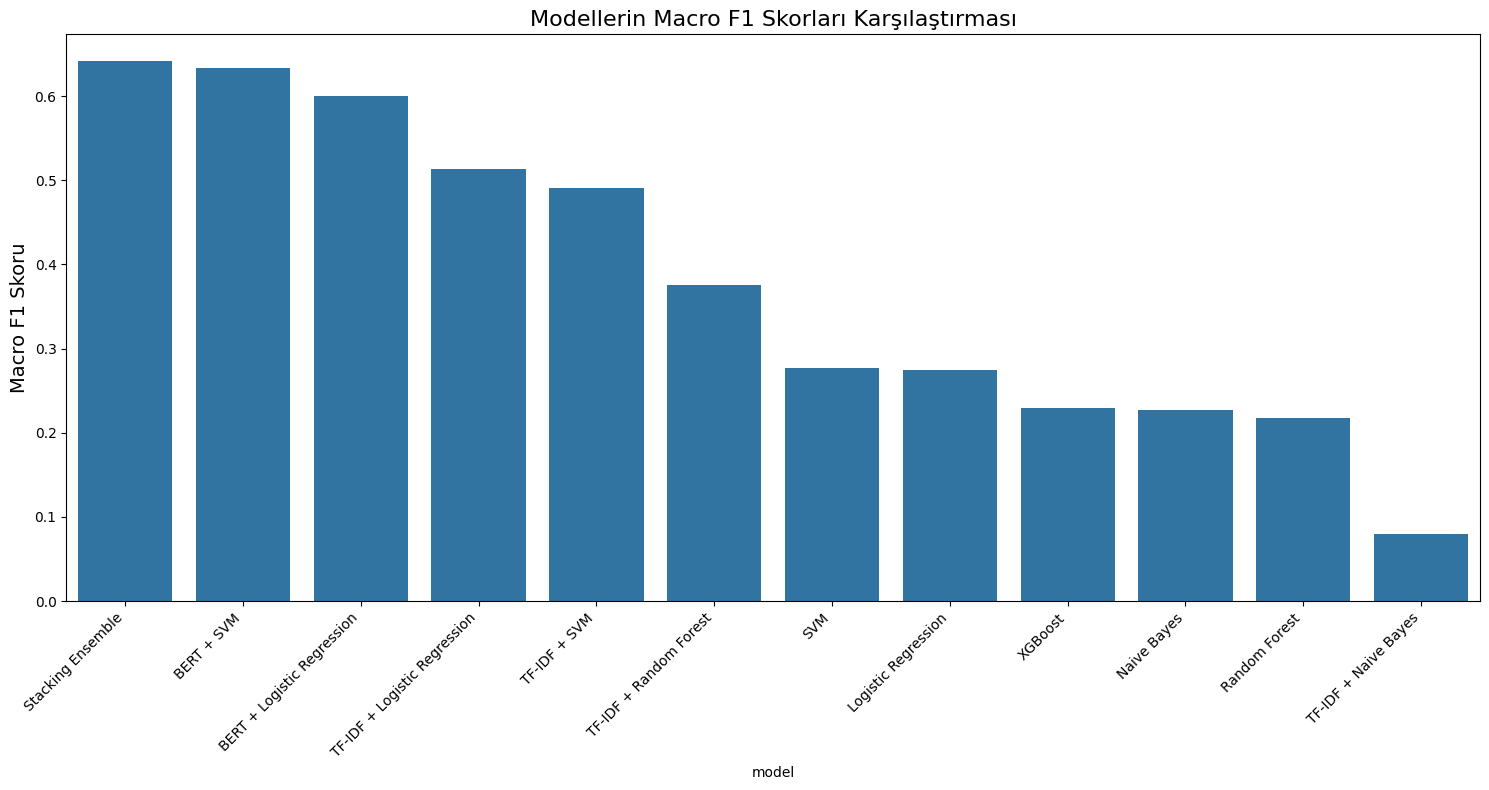

In [22]:
# Modellerin seçimi, eğitimi ve değerlendirilimesi

# Modellerin seçimi, eğitimi ve değerlendirilimesi

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import joblib
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleri eğitmek ve değerlendirmek için fonksiyon
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Performans metrikleri
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Detaylı rapor
    # label_encoder değişkeninin sizin önceki kodunuzda tanımlı olduğunu varsayıyorum.
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Sonuçları kaydet
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'classification_report': report,
        'confusion_matrix': cm,
        'model': model
    }

    return results

# 1. Stilometrik özelliklerle modeller
stylometric_models = [
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])),
    ('SVM', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ])),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]

stylometric_results = []
for name, model in stylometric_models:
    print(f"\n{name} modeli eğitiliyor...")
    result = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    stylometric_results.append(result)
    print(f"{name} - Test Accuracy: {result['accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")

    # Modeli kaydet
    joblib.dump(result['model'], f'{name.lower().replace(" ", "_")}_stylometric_model.pkl')

# 2. TF-IDF özellikleriyle modeller
# Düzeltme: MultinomialNB negatif değer kabul etmediği için TF-IDF + Naive Bayes modelini
# MinMaxScaler ile pipeline içine aldım (0..1 aralığına taşıyarak negatifleri ortadan kaldırıyoruz).
tfidf_models = [
    ('TF-IDF + Naive Bayes', Pipeline([
        ('scaler', MinMaxScaler()),    # <-- burada düzeltme
        ('clf', MultinomialNB())
    ])),
    ('TF-IDF + Logistic Regression', Pipeline([
        ('clf', LogisticRegression(max_iter=1000, random_state=42, C=1.0))
    ])),
    ('TF-IDF + SVM', Pipeline([
        ('clf', SVC(kernel='linear', probability=True, random_state=42, C=1.0))
    ])),
    ('TF-IDF + Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# TF-IDF veri setini bölme
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    tfidf_reduced, y, test_size=0.2, random_state=42, stratify=y
)

tfidf_results = []
for name, model in tfidf_models:
    print(f"\n{name} modeli eğitiliyor...")
    result = evaluate_model(model, X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test, name)
    tfidf_results.append(result)
    print(f"{name} - Test Accuracy: {result['accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")

    # Modeli kaydet
    joblib.dump(result['model'], f'{name.lower().replace(" ", "_").replace("+", "")}_tfidf_model.pkl')

# 3. DistilBERT Embedding'leri ile modeller
bert_models = [
    ('BERT + Logistic Regression', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])),
    ('BERT + SVM', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ]))
]

# BERT veri setini bölme
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
    bert_embeddings, y, test_size=0.2, random_state=42, stratify=y
)

bert_results = []
for name, model in bert_models:
    print(f"\n{name} modeli eğitiliyor...")
    result = evaluate_model(model, X_bert_train, y_bert_train, X_bert_test, y_bert_test, name)
    bert_results.append(result)
    print(f"{name} - Test Accuracy: {result['accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")

    # Modeli kaydet
    joblib.dump(result['model'], f'{name.lower().replace(" ", "_").replace("+", "")}_bert_model.pkl')

# 4. Ensemble model (Farklı kaynaklardan gelen özellikleri birleştirme)
from sklearn.ensemble import StackingClassifier

# Özellikleri birleştirme
# Not: burada X_train, X_tfidf_train, X_bert_train satırlarının aynı örnek sıralamasına sahip
# olduğunu varsayıyorum (aynı random_state ve stratify kullanılarak split edildiyse genelde aynıdır).
X_combined_train = np.hstack([X_train.values, X_tfidf_train, X_bert_train])
X_combined_test = np.hstack([X_test.values, X_tfidf_test, X_bert_test])

# Base modeller
base_models = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

print("\nStacking Ensemble modeli eğitiliyor...")
ensemble_result = evaluate_model(stacking_clf, X_combined_train, y_tfidf_train, X_combined_test, y_tfidf_test, 'Stacking Ensemble')
print(f"Ensemble - Test Accuracy: {ensemble_result['accuracy']:.4f}, Macro F1: {ensemble_result['macro_f1']:.4f}")

# Sonuçları bir araya getirme ve karşılaştırma
all_results = stylometric_results + tfidf_results + bert_results + [ensemble_result]
results_df = pd.DataFrame([{
    'model': r['model_name'],
    'accuracy': r['accuracy'],
    'macro_f1': r['macro_f1'],
    'weighted_f1': r['weighted_f1'],
    'training_time': r['training_time']
} for r in all_results])

# Sonuçları görselleştirme
plt.figure(figsize=(15, 8))
sns.barplot(x='model', y='macro_f1', data=results_df.sort_values('macro_f1', ascending=False))
plt.xticks(rotation=45, ha='right')
plt.title('Modellerin Macro F1 Skorları Karşılaştırması', fontsize=16)
plt.ylabel('Macro F1 Skoru', fontsize=14)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()


In [23]:
# Model Yorumlanabilirliği ve Öznitelik Önem Derecesi

# En iyi performans gösteren modeli seçme
best_model_result = max(all_results, key=lambda x: x['macro_f1'])
best_model = best_model_result['model']
best_model_name = best_model_result['model_name']

print(f"\nEn iyi model: {best_model_name} (Macro F1: {best_model_result['macro_f1']:.4f})")

# Özellik önem derecesi analizi (Random Forest veya XGBoost için)
if 'Random Forest' in best_model_name or 'XGBoost' in best_model_name:
    if hasattr(best_model, 'named_steps'):
        feature_importances = best_model.named_steps['clf'].feature_importances_
    else:
        feature_importances = best_model.feature_importances_

    feature_names = X.columns if isinstance(best_model, Pipeline) else X.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(f'{best_model_name} - En Önemli Özellikler', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{best_model_name.lower().replace(" ", "_")}_feature_importance.png')
    plt.show()

# SHAP analizi (daha derin yorumlanabilirlik için)
if 'XGBoost' in best_model_name:
    import shap

    explainer = shap.TreeExplainer(best_model.named_steps['clf'] if hasattr(best_model, 'named_steps') else best_model)
    shap_values = explainer.shap_values(X_test.values if hasattr(X_test, 'values') else X_test)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test.values if hasattr(X_test, 'values') else X_test, feature_names=X.columns, max_display=20, show=False)
    plt.title(f'{best_model_name} - SHAP Değerleri', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{best_model_name.lower().replace(" ", "_")}_shap_summary.png')
    plt.show()


En iyi model: Stacking Ensemble (Macro F1: 0.6412)
